# Trainable Wavelet Fusion Model Option 2 - Testing and Evaluation

This notebook tests the trained spatial-adaptive wavelet fusion model (Option 2) on sample CT-MRI image pairs and evaluates the fusion quality with comprehensive metrics and visualizations.

## Key Features of Option 2 Model:
- **Spatial-Adaptive Fusion**: Uses CNN-based masks for location-aware fusion
- **Enhanced Loss Function**: Combines L1, SSIM, and gradient losses
- **High-Frequency Detail Preservation**: Better edge and texture preservation
- **Trainable Fusion Weights**: Learned spatial masks for optimal fusion

## 1. Import Required Libraries

In [1]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import seaborn as sns
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# PyWavelets and pytorch_wavelets for wavelet transforms
from pytorch_wavelets import DWTForward, DWTInverse

# Import evaluation metrics
from skimage.metrics import structural_similarity as ssim

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set matplotlib style
plt.style.use('default')
sns.set_palette("husl")

Using device: cuda


## 2. Define Model Architecture and Evaluation Functions

Define the spatial-adaptive wavelet fusion model and evaluation metrics.

In [2]:
class WaveletFusionNetSpatial(nn.Module):
    def __init__(self, wave='haar'):
        super().__init__()
        self.dwt = DWTForward(J=1, wave=wave)
        self.idwt = DWTInverse(wave=wave)
        self.mask_net = nn.Sequential(
            nn.Conv2d(2,16,3,padding=1), nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,4,3,padding=1), nn.Sigmoid()
        )

    def forward(self, ct, mr):
        # --- Ensure 4D ---
        if ct.dim() == 3: ct = ct.unsqueeze(0)
        if mr.dim() == 3: mr = mr.unsqueeze(0)

        # --- DWT decomposition ---
        ct_low, ct_high = self.dwt(ct)
        mr_low, mr_high = self.dwt(mr)

        # --- Split high-frequency channels ---
        ct_lh, ct_hl, ct_hh = ct_high[0][:,:,0:1,:,:], ct_high[0][:,:,1:2,:,:], ct_high[0][:,:,2:3,:,:]
        mr_lh, mr_hl, mr_hh = mr_high[0][:,:,0:1,:,:], mr_high[0][:,:,1:2,:,:], mr_high[0][:,:,2:3,:,:]
        
        # Squeeze the extra dimension to get [batch, channels, H, W]
        ct_lh, ct_hl, ct_hh = ct_lh.squeeze(2), ct_hl.squeeze(2), ct_hh.squeeze(2)
        mr_lh, mr_hl, mr_hh = mr_lh.squeeze(2), mr_hl.squeeze(2), mr_hh.squeeze(2)

        # --- Low-frequency mask input ---
        low_stack = torch.cat([ct_low, mr_low], dim=1)
        masks_low = self.mask_net(low_stack)
        mL, mLH_small, mHL_small, mHH_small = masks_low[:,0:1], masks_low[:,1:2], masks_low[:,2:3], masks_low[:,3:4]
        
        # Resize high-frequency masks to match high-frequency component dimensions
        high_freq_size = (ct_lh.shape[2], ct_lh.shape[3])
        mLH = F.interpolate(mLH_small, size=high_freq_size, mode='bilinear', align_corners=False)
        mHL = F.interpolate(mHL_small, size=high_freq_size, mode='bilinear', align_corners=False)
        mHH = F.interpolate(mHH_small, size=high_freq_size, mode='bilinear', align_corners=False)

        # --- Fuse low-frequency ---
        fused_low = mL*ct_low + (1-mL)*mr_low

        # --- Fuse high-frequency ---
        fused_lh = mLH*ct_lh + (1-mLH)*mr_lh
        fused_hl = mHL*ct_hl + (1-mHL)*mr_hl
        fused_hh = mHH*ct_hh + (1-mHH)*mr_hh
        
        # Stack them back to the original format for inverse DWT
        fused_high = torch.stack([fused_lh, fused_hl, fused_hh], dim=2)

        # --- Inverse DWT ---
        fused = self.idwt((fused_low, [fused_high]))
        return fused, {'mL': mL, 'mLH': mLH, 'mHL': mHL, 'mHH': mHH}

In [3]:
# Comprehensive evaluation functions
def calculate_ssim(img1, img2):
    """Calculate SSIM between two images."""
    return ssim(img1, img2, data_range=1.0)

def calculate_psnr(img1, img2):
    """Calculate PSNR between two images."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))

def calculate_gradient_magnitude(img):
    """Calculate gradient magnitude using Sobel operators."""
    img_uint8 = (img * 255).astype(np.uint8)
    grad_x = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    return np.sqrt(grad_x**2 + grad_y**2) / 255.0

def calculate_edge_preservation(fused, ct, mri):
    """Calculate edge preservation metric."""
    grad_fused = calculate_gradient_magnitude(fused)
    grad_ct = calculate_gradient_magnitude(ct)
    grad_mri = calculate_gradient_magnitude(mri)
    grad_max = np.maximum(grad_ct, grad_mri)
    correlation = np.corrcoef(grad_fused.flatten(), grad_max.flatten())[0, 1]
    return correlation if not np.isnan(correlation) else 0.0

def calculate_entropy(img):
    """Calculate image entropy."""
    img_uint8 = (img * 255).astype(np.uint8)
    hist, _ = np.histogram(img_uint8, bins=256, range=(0, 256))
    hist = hist / hist.sum()
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

def calculate_mutual_information(img1, img2):
    """Calculate mutual information between two images."""
    img1_uint8 = (img1 * 255).astype(np.uint8)
    img2_uint8 = (img2 * 255).astype(np.uint8)
    hist_2d, _, _ = np.histogram2d(img1_uint8.flatten(), img2_uint8.flatten(), bins=256)
    hist_2d = hist_2d / hist_2d.sum()
    hist_1 = hist_2d.sum(axis=1)
    hist_2 = hist_2d.sum(axis=0)
    mi = 0.0
    for i in range(256):
        for j in range(256):
            if hist_2d[i, j] > 0 and hist_1[i] > 0 and hist_2[j] > 0:
                mi += hist_2d[i, j] * np.log2(hist_2d[i, j] / (hist_1[i] * hist_2[j]))
    return mi

def evaluate_fusion_quality(fused, ct, mri):
    """Comprehensive evaluation of fusion quality."""
    if fused is None:
        return {}
    
    metrics = {}
    metrics['SSIM_CT'] = calculate_ssim(fused, ct)
    metrics['SSIM_MRI'] = calculate_ssim(fused, mri)
    metrics['SSIM_Avg'] = (metrics['SSIM_CT'] + metrics['SSIM_MRI']) / 2
    metrics['PSNR_CT'] = calculate_psnr(fused, ct)
    metrics['PSNR_MRI'] = calculate_psnr(fused, mri)
    metrics['PSNR_Avg'] = (metrics['PSNR_CT'] + metrics['PSNR_MRI']) / 2
    metrics['Edge_Preservation'] = calculate_edge_preservation(fused, ct, mri)
    metrics['Entropy'] = calculate_entropy(fused)
    metrics['MI_CT'] = calculate_mutual_information(fused, ct)
    metrics['MI_MRI'] = calculate_mutual_information(fused, mri)
    metrics['MI_Avg'] = (metrics['MI_CT'] + metrics['MI_MRI']) / 2
    
    return metrics

## 3. Load the Trained Model

Load the trained spatial-adaptive wavelet fusion model.

Loading spatial-adaptive wavelet fusion model from checkpoints_enhanced/wavelet_fusion_spatial_best.pt
✅ Model loaded successfully!

📊 Model Information:
   Training epoch: 20
   Best loss: 0.6350
   Model type: WaveletFusionNetSpatial
   Wavelet type: haar
   Loss weights: {'w_l1': 1.0, 'w_ssim': 1.0, 'w_grad': 0.5}
   Training history loaded: 20 epochs


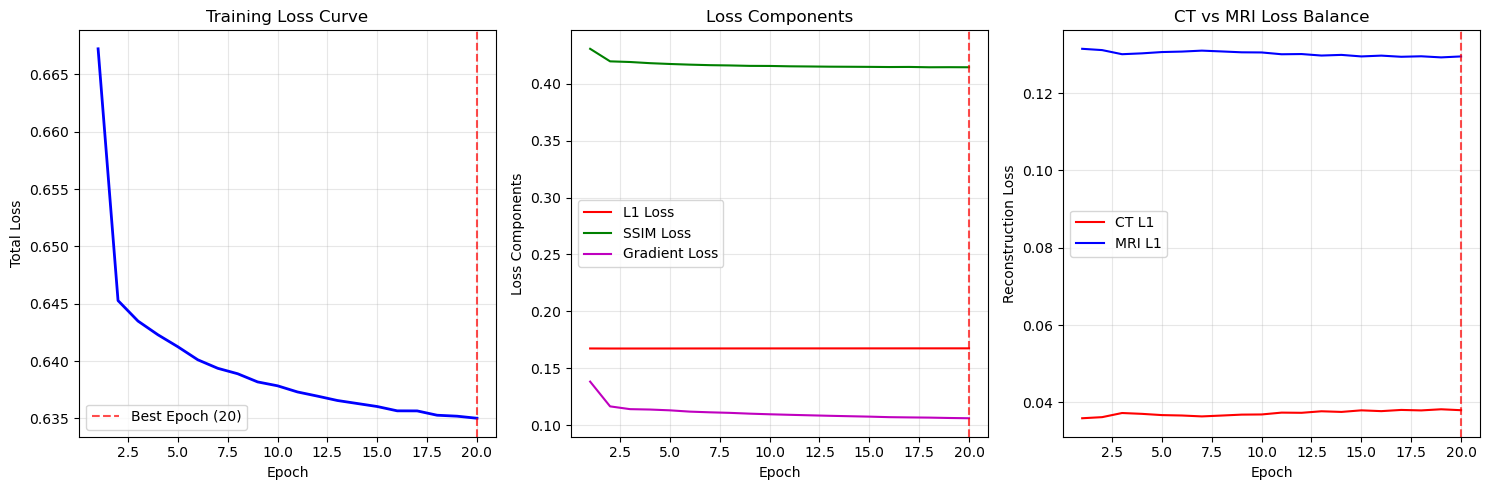


🚀 Model ready for testing!


In [4]:
# Load the trained model
model_path = 'checkpoints_enhanced/wavelet_fusion_spatial_best.pt'
if os.path.exists(model_path):
    print(f"Loading spatial-adaptive wavelet fusion model from {model_path}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Initialize model
    wave_type = 'haar'  # Default
    if 'model_config' in checkpoint and 'wave' in checkpoint['model_config']:
        wave_type = checkpoint['model_config']['wave']
    
    model = WaveletFusionNetSpatial(wave=wave_type).to(device)
    
    # Load model state dict
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Model loaded successfully!")
        
        # Display checkpoint information
        print(f"\n📊 Model Information:")
        print(f"   Training epoch: {checkpoint['epoch']}")
        print(f"   Best loss: {checkpoint['best_loss']:.4f}")
        print(f"   Model type: {checkpoint['model_config']['model_type']}")
        print(f"   Wavelet type: {checkpoint['model_config']['wave']}")
        print(f"   Loss weights: {checkpoint['model_config']['loss_weights']}")
        
    else:
        print("❌ Error: Invalid checkpoint format. Expected 'model_state_dict' key.")
        model = None
    
    if model is not None:
        model.eval()
        
        # Load training history if available
        history_path = 'checkpoints_enhanced/training_history.pt'
        if os.path.exists(history_path):
            training_history = torch.load(history_path, map_location='cpu')
            print(f"   Training history loaded: {len(training_history['epoch_metrics'])} epochs")
            
            # Plot training history
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            epochs_range = range(1, len(training_history['epoch_metrics']) + 1)
            plt.plot(epochs_range, [m['total'] for m in training_history['epoch_metrics']], 'b-', linewidth=2)
            plt.axvline(x=training_history['best_epoch'], color='red', linestyle='--', alpha=0.7, label=f'Best Epoch ({training_history["best_epoch"]})')
            plt.xlabel('Epoch')
            plt.ylabel('Total Loss')
            plt.title('Training Loss Curve')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 3, 2)
            plt.plot(epochs_range, [m['l1'] for m in training_history['epoch_metrics']], 'r-', label='L1 Loss')
            plt.plot(epochs_range, [m['ssim'] for m in training_history['epoch_metrics']], 'g-', label='SSIM Loss')
            plt.plot(epochs_range, [m['gradient'] for m in training_history['epoch_metrics']], 'm-', label='Gradient Loss')
            plt.axvline(x=training_history['best_epoch'], color='red', linestyle='--', alpha=0.7)
            plt.xlabel('Epoch')
            plt.ylabel('Loss Components')
            plt.title('Loss Components')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 3, 3)
            plt.plot(epochs_range, [m['l1_ct'] for m in training_history['epoch_metrics']], 'r-', label='CT L1')
            plt.plot(epochs_range, [m['l1_mr'] for m in training_history['epoch_metrics']], 'b-', label='MRI L1')
            plt.axvline(x=training_history['best_epoch'], color='red', linestyle='--', alpha=0.7)
            plt.xlabel('Epoch')
            plt.ylabel('Reconstruction Loss')
            plt.title('CT vs MRI Loss Balance')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        print(f"\n🚀 Model ready for testing!")
        
else:
    print(f"❌ Model checkpoint not found at {model_path}")
    print("📝 Please train the model first using trainable_wavelet_fusion_option2.ipynb")
    print("📂 Expected checkpoint structure:")
    print("   checkpoints_enhanced/")
    print("   ├── wavelet_fusion_spatial_best.pt")
    print("   ├── training_history.pt")
    print("   └── wavelet_fusion_spatial_epoch_*.pt")
    model = None

## 4. Load and Preprocess Test Images

Define helper functions to load and preprocess CT-MRI image pairs.

In [5]:
def load_image_pair(ct_path, mri_path, resize=None):
    """Load and preprocess a CT-MRI image pair."""
    ct = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
    mri = cv2.imread(mri_path, cv2.IMREAD_GRAYSCALE)
    
    if ct is None or mri is None:
        raise FileNotFoundError(f"Could not load images: {ct_path}, {mri_path}")
    
    if resize is not None:
        H, W = resize
        ct = cv2.resize(ct, (W, H), interpolation=cv2.INTER_AREA)
        mri = cv2.resize(mri, (W, H), interpolation=cv2.INTER_AREA)
    
    # Normalize to [0, 1]
    ct = ct.astype(np.float32)
    mri = mri.astype(np.float32)
    if ct.max() > 1.0: ct /= 255.0
    if mri.max() > 1.0: mri /= 255.0
    
    return ct, mri

def get_test_image_pairs(ct_dir, mri_dir, num_samples=5):
    """Get a list of test image pairs."""
    ct_files = sorted(glob.glob(os.path.join(ct_dir, '*.png')))
    mri_files = sorted(glob.glob(os.path.join(mri_dir, '*.png')))
    
    # Match files by basename
    pairs = []
    for ct_file in ct_files:
        ct_basename = os.path.basename(ct_file)
        mri_file = os.path.join(mri_dir, ct_basename)
        if os.path.exists(mri_file):
            pairs.append((ct_file, mri_file))
    
    # Select a subset for testing
    if len(pairs) > num_samples:
        indices = np.linspace(0, len(pairs)-1, num_samples, dtype=int)
        pairs = [pairs[i] for i in indices]
    
    return pairs

# Get test image pairs
ct_test_dir = 'Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/test/CT'
mri_test_dir = 'Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/test/MRI'

test_pairs = get_test_image_pairs(ct_test_dir, mri_test_dir, num_samples=6)
print(f"Found {len(test_pairs)} test image pairs")

for i, (ct_path, mri_path) in enumerate(test_pairs[:3]):
    print(f"  Pair {i+1}: {os.path.basename(ct_path)}")

Found 6 test image pairs
  Pair 1: 16009.png
  Pair 2: 16013.png
  Pair 3: 2010.png


## 5. Perform Image Fusion

Define fusion methods including the trained model and baseline methods for comparison.

In [6]:
def fuse_with_spatial_model(model, ct, mri):
    """Fuse images using the trained spatial-adaptive model."""
    if model is None:
        return None, None
    
    with torch.no_grad():
        # Convert to tensors and add batch dimension
        ct_tensor = torch.from_numpy(ct)[None, None, ...].to(device)
        mri_tensor = torch.from_numpy(mri)[None, None, ...].to(device)
        
        # Perform fusion and get masks
        fused_tensor, masks = model(ct_tensor, mri_tensor)
        
        # Convert back to numpy
        fused = fused_tensor.squeeze().cpu().numpy()
        
        # Convert masks to numpy
        mask_data = {}
        for key, mask_tensor in masks.items():
            mask_data[key] = mask_tensor.squeeze().cpu().numpy()
        
        return np.clip(fused, 0, 1), mask_data

def fuse_average(ct, mri):
    """Simple average fusion."""
    return 0.5 * (ct + mri)

def fuse_max(ct, mri):
    """Max-based fusion."""
    return np.maximum(ct, mri)

def fuse_weighted(ct, mri, weight=0.6):
    """Weighted fusion favoring CT."""
    return weight * ct + (1 - weight) * mri

# Test fusion on the first image pair
if test_pairs and model is not None:
    ct_path, mri_path = test_pairs[0]
    ct_img, mri_img = load_image_pair(ct_path, mri_path)
    
    print(f"Testing fusion on: {os.path.basename(ct_path)}")
    print(f"Image shape: {ct_img.shape}")
    print(f"CT range: [{ct_img.min():.3f}, {ct_img.max():.3f}]")
    print(f"MRI range: [{mri_img.min():.3f}, {mri_img.max():.3f}]")
    
    # Test spatial-adaptive fusion
    fused_spatial, spatial_masks = fuse_with_spatial_model(model, ct_img, mri_img)
    if fused_spatial is not None:
        print(f"Fused range: [{fused_spatial.min():.3f}, {fused_spatial.max():.3f}]")
        print("✅ Spatial-adaptive fusion successful!")
        
        # Display mask statistics
        print("\nLearned Spatial Masks Statistics:")
        for mask_name, mask in spatial_masks.items():
            print(f"  {mask_name}: mean={mask.mean():.3f}, std={mask.std():.3f}, range=[{mask.min():.3f}, {mask.max():.3f}]")
    else:
        print("❌ Spatial fusion failed")

Testing fusion on: 16009.png
Image shape: (256, 256)
CT range: [0.000, 1.000]
MRI range: [0.000, 1.000]
Fused range: [0.000, 1.000]
✅ Spatial-adaptive fusion successful!

Learned Spatial Masks Statistics:
  mL: mean=0.540, std=0.208, range=[0.001, 1.000]
  mLH: mean=0.497, std=0.220, range=[0.001, 1.000]
  mHL: mean=0.504, std=0.220, range=[0.001, 1.000]
  mHH: mean=0.525, std=0.208, range=[0.004, 0.999]


## 6. Display Fusion Results with Spatial Masks

Visualize the fusion results and learned spatial masks.

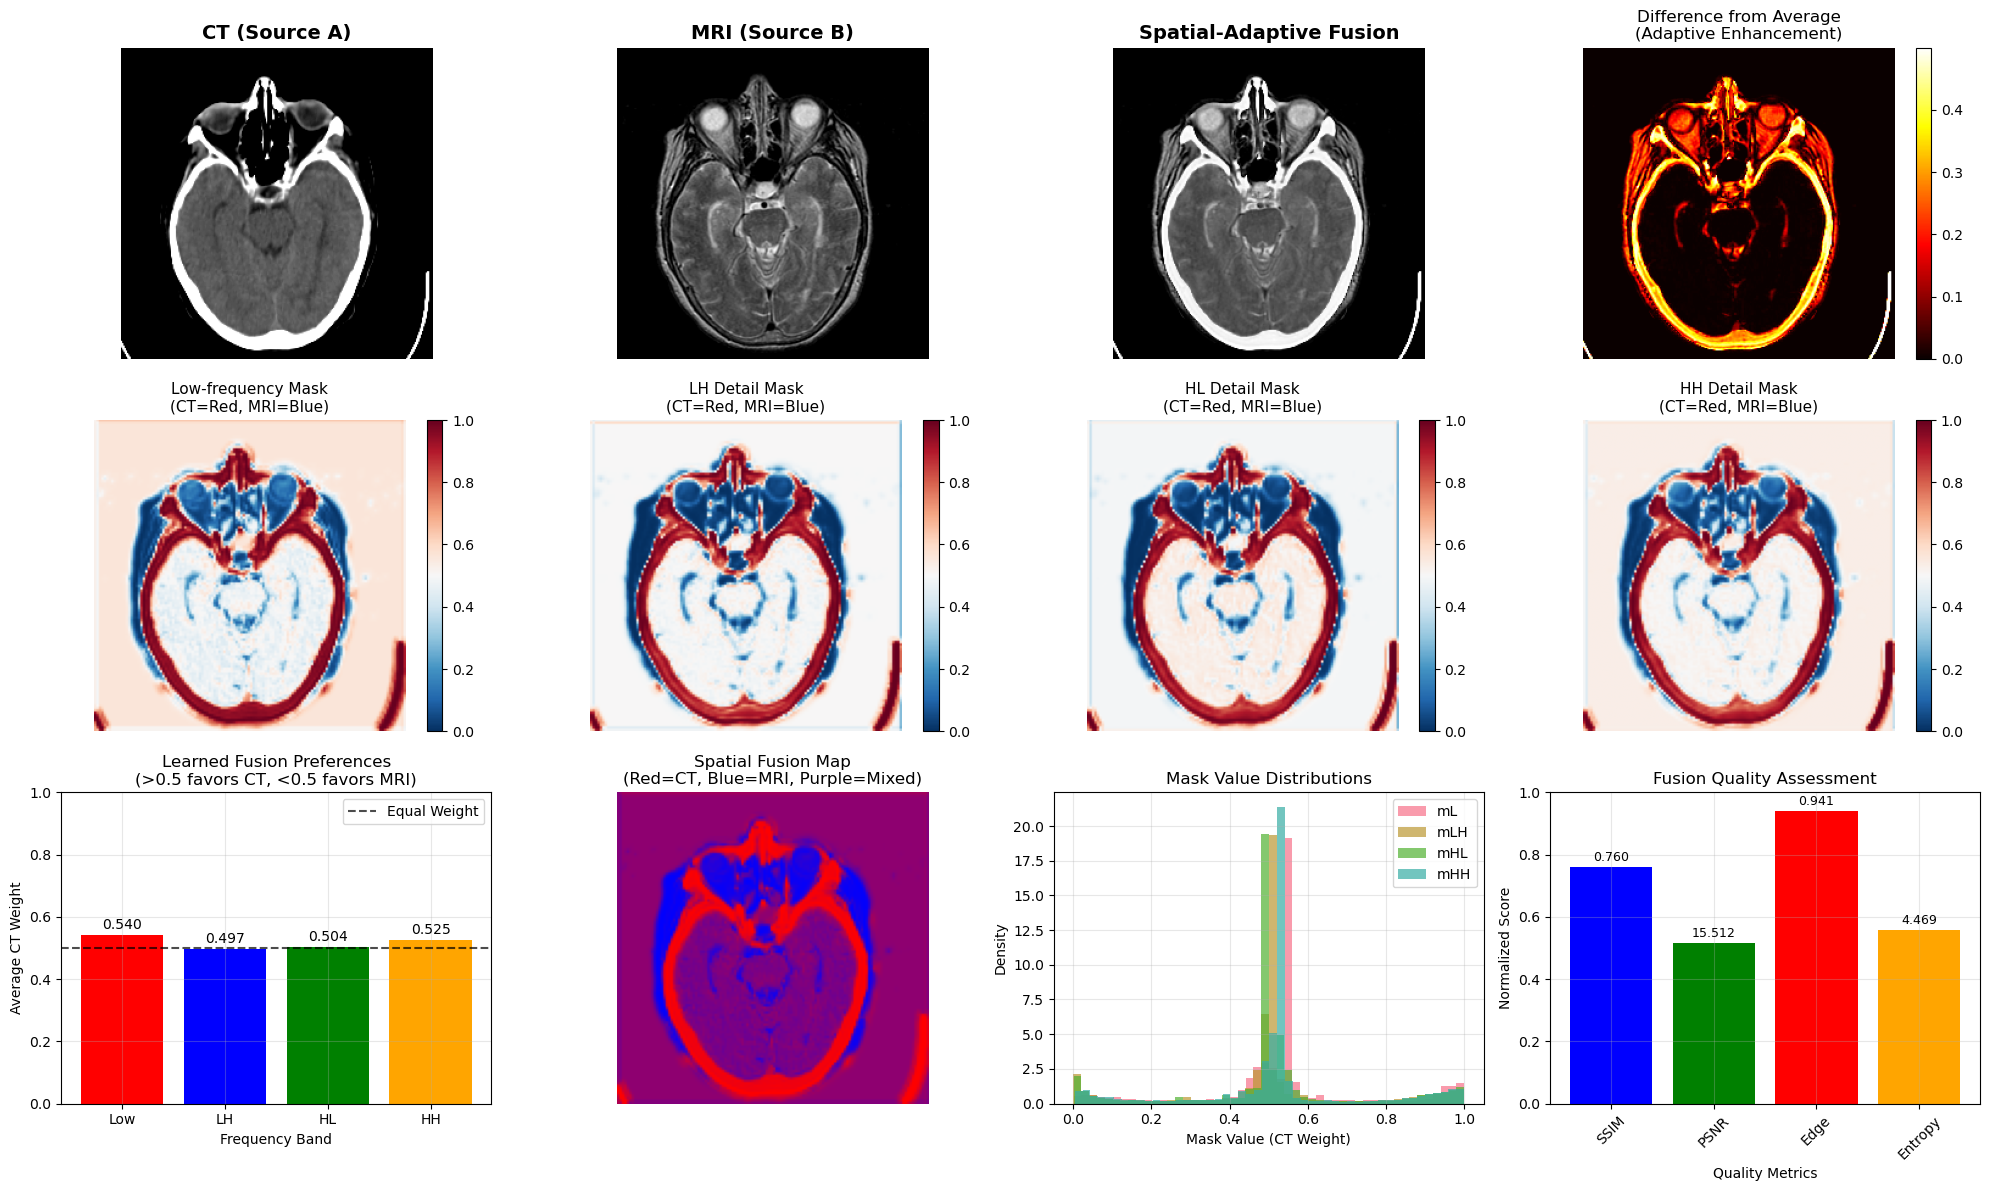

In [7]:
def display_spatial_fusion_results(ct, mri, fused, masks, figsize=(20, 12)):
    """Display original images, fusion result, and learned spatial masks."""
    plt.figure(figsize=figsize)
    
    # Original images and fusion result
    plt.subplot(3, 4, 1)
    plt.imshow(ct, cmap='gray')
    plt.title('CT (Source A)', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(3, 4, 2)
    plt.imshow(mri, cmap='gray')
    plt.title('MRI (Source B)', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(3, 4, 3)
    plt.imshow(fused, cmap='gray')
    plt.title('Spatial-Adaptive Fusion', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    # Difference map
    plt.subplot(3, 4, 4)
    diff = np.abs(fused - 0.5 * (ct + mri))
    plt.imshow(diff, cmap='hot')
    plt.title('Difference from Average\n(Adaptive Enhancement)', fontsize=12)
    plt.colorbar()
    plt.axis('off')
    
    # Spatial masks
    mask_titles = {
        'mL': 'Low-frequency Mask\n(CT=Red, MRI=Blue)',
        'mLH': 'LH Detail Mask\n(CT=Red, MRI=Blue)', 
        'mHL': 'HL Detail Mask\n(CT=Red, MRI=Blue)',
        'mHH': 'HH Detail Mask\n(CT=Red, MRI=Blue)'
    }
    
    for i, (mask_name, mask_title) in enumerate(mask_titles.items()):
        plt.subplot(3, 4, 5 + i)
        mask = masks[mask_name]
        plt.imshow(mask, cmap='RdBu_r', vmin=0, vmax=1)
        plt.title(mask_title, fontsize=11)
        plt.colorbar()
        plt.axis('off')
    
    # Mask analysis
    plt.subplot(3, 4, 9)
    mask_names = list(masks.keys())
    mask_means = [masks[name].mean() for name in mask_names]
    bars = plt.bar(range(len(mask_names)), mask_means, color=['red', 'blue', 'green', 'orange'])
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.7, label='Equal Weight')
    plt.xlabel('Frequency Band')
    plt.ylabel('Average CT Weight')
    plt.title('Learned Fusion Preferences\n(>0.5 favors CT, <0.5 favors MRI)')
    plt.xticks(range(len(mask_names)), ['Low', 'LH', 'HL', 'HH'])
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars, mask_means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom')
    
    # Spatial distribution analysis
    plt.subplot(3, 4, 10)
    # Create RGB image showing spatial preference
    h, w = masks['mL'].shape
    rgb_mask = np.zeros((h, w, 3))
    rgb_mask[:, :, 0] = masks['mL']  # Red channel for CT preference
    rgb_mask[:, :, 2] = 1 - masks['mL']  # Blue channel for MRI preference
    plt.imshow(rgb_mask)
    plt.title('Spatial Fusion Map\n(Red=CT, Blue=MRI, Purple=Mixed)')
    plt.axis('off')
    
    # Mask histogram
    plt.subplot(3, 4, 11)
    for i, (name, mask) in enumerate(masks.items()):
        plt.hist(mask.flatten(), bins=50, alpha=0.7, label=name, density=True)
    plt.xlabel('Mask Value (CT Weight)')
    plt.ylabel('Density')
    plt.title('Mask Value Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Quality metrics
    plt.subplot(3, 4, 12)
    metrics = evaluate_fusion_quality(fused, ct, mri)
    metrics_names = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy']
    metrics_values = [
        metrics['SSIM_Avg'], 
        metrics['PSNR_Avg']/30,  # Normalize PSNR
        metrics['Edge_Preservation'], 
        metrics['Entropy']/8     # Normalize entropy
    ]
    
    bars = plt.bar(range(len(metrics_names)), metrics_values, 
                   color=['blue', 'green', 'red', 'orange'])
    plt.xlabel('Quality Metrics')
    plt.ylabel('Normalized Score')
    plt.title('Fusion Quality Assessment')
    plt.xticks(range(len(metrics_names)), ['SSIM', 'PSNR', 'Edge', 'Entropy'], rotation=45)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, metrics_values)):
        actual_val = [metrics['SSIM_Avg'], metrics['PSNR_Avg'], metrics['Edge_Preservation'], metrics['Entropy']][i]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{actual_val:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Display results for the first test image
if test_pairs and model is not None and fused_spatial is not None:
    display_spatial_fusion_results(ct_img, mri_img, fused_spatial, spatial_masks)

## 7. Comprehensive Comparison Analysis

Compare the spatial-adaptive model with baseline fusion methods.

In [8]:
# Comprehensive comparison of fusion methods
print("=" * 90)
print("COMPARATIVE ANALYSIS: SPATIAL-ADAPTIVE MODEL vs BASELINE METHODS")
print("=" * 90)

def comprehensive_fusion_comparison(model, test_pairs, num_tests=5):
    """Compare spatial-adaptive fusion with baseline methods."""
    
    test_results = []
    num_test_images = min(num_tests, len(test_pairs))
    
    print(f"Testing {num_test_images} image pairs...\n")
    
    for test_idx in range(num_test_images):
        ct_path, mri_path = test_pairs[test_idx]
        ct_img, mri_img = load_image_pair(ct_path, mri_path)
        
        print(f"Test Image {test_idx + 1}: {os.path.basename(ct_path)}")
        print("-" * 50)
        
        # Different fusion methods
        fusion_methods = {}
        
        # Spatial-adaptive model
        if model is not None:
            fused_spatial, masks = fuse_with_spatial_model(model, ct_img, mri_img)
            if fused_spatial is not None:
                fusion_methods['Spatial-Adaptive Model'] = fused_spatial
        
        # Baseline methods
        fusion_methods['Average'] = fuse_average(ct_img, mri_img)
        fusion_methods['Maximum'] = fuse_max(ct_img, mri_img)
        fusion_methods['Weighted (0.6)'] = fuse_weighted(ct_img, mri_img, 0.6)
        
        # Evaluate each method
        method_results = {}
        for method_name, fused_img in fusion_methods.items():
            metrics = evaluate_fusion_quality(fused_img, ct_img, mri_img)
            method_results[method_name] = metrics
            
            print(f"  {method_name:20s}: SSIM={metrics['SSIM_Avg']:.3f}, "
                  f"PSNR={metrics['PSNR_Avg']:.1f}dB, "
                  f"Edge={metrics['Edge_Preservation']:.3f}, "
                  f"Entropy={metrics['Entropy']:.2f}")
        
        test_results.append({
            'image_idx': test_idx,
            'image_name': os.path.basename(ct_path),
            'methods': method_results,
            'ct_img': ct_img,
            'mri_img': mri_img,
            'fusion_results': fusion_methods
        })
        print()
    
    return test_results

# Perform comprehensive comparison
if model is not None:
    comparison_results = comprehensive_fusion_comparison(model, test_pairs, num_tests=5)
    
    # Aggregate statistics
    print("AGGREGATE PERFORMANCE STATISTICS")
    print("=" * 50)
    
    metrics_names = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']
    method_names = list(comparison_results[0]['methods'].keys())
    
    aggregate_stats = {}
    for method in method_names:
        aggregate_stats[method] = {}
        for metric in metrics_names:
            values = [result['methods'][method][metric] for result in comparison_results]
            aggregate_stats[method][metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values)
            }
    
    # Display aggregate statistics
    for method in method_names:
        print(f"\n{method}:")
        print(f"  SSIM:      {aggregate_stats[method]['SSIM_Avg']['mean']:.3f} ± {aggregate_stats[method]['SSIM_Avg']['std']:.3f}")
        print(f"  PSNR:      {aggregate_stats[method]['PSNR_Avg']['mean']:.1f} ± {aggregate_stats[method]['PSNR_Avg']['std']:.1f} dB")
        print(f"  Edge Pres: {aggregate_stats[method]['Edge_Preservation']['mean']:.3f} ± {aggregate_stats[method]['Edge_Preservation']['std']:.3f}")
        print(f"  Entropy:   {aggregate_stats[method]['Entropy']['mean']:.2f} ± {aggregate_stats[method]['Entropy']['std']:.2f} bits")
        print(f"  MI:        {aggregate_stats[method]['MI_Avg']['mean']:.3f} ± {aggregate_stats[method]['MI_Avg']['std']:.3f} bits")
    
    # Performance ranking
    print(f"\nPERFORMANCE RANKING")
    print("=" * 30)
    
    for metric in metrics_names:
        print(f"\nBest {metric}:")
        sorted_methods = sorted(method_names, 
                               key=lambda x: aggregate_stats[x][metric]['mean'], 
                               reverse=True)
        for i, method in enumerate(sorted_methods, 1):
            value = aggregate_stats[method][metric]['mean']
            print(f"  {i}. {method:25s}: {value:.3f}")
    
    # Overall quality score
    overall_scores = {}
    for method in method_names:
        score = (0.3 * aggregate_stats[method]['SSIM_Avg']['mean'] +
                 0.25 * min(aggregate_stats[method]['PSNR_Avg']['mean']/30, 1.0) +
                 0.25 * aggregate_stats[method]['Edge_Preservation']['mean'] +
                 0.1 * min(aggregate_stats[method]['Entropy']['mean']/8, 1.0) +
                 0.1 * min(aggregate_stats[method]['MI_Avg']['mean']/3, 1.0))
        overall_scores[method] = score
    
    best_overall = max(overall_scores, key=overall_scores.get)
    print(f"\nOVERALL PERFORMANCE RANKING:")
    print("-" * 40)
    sorted_overall = sorted(overall_scores.items(), key=lambda x: x[1], reverse=True)
    for i, (method, score) in enumerate(sorted_overall, 1):
        print(f"  {i}. {method:25s}: {score:.3f}")
    
    print(f"\n🏆 Best Overall Method: {best_overall}")
    
else:
    print("❌ Model not available for comparison")

COMPARATIVE ANALYSIS: SPATIAL-ADAPTIVE MODEL vs BASELINE METHODS
Testing 5 image pairs...

Test Image 1: 16009.png
--------------------------------------------------
  Spatial-Adaptive Model: SSIM=0.760, PSNR=15.5dB, Edge=0.941, Entropy=4.47
  Average             : SSIM=0.741, PSNR=17.2dB, Edge=0.955, Entropy=4.39
  Maximum             : SSIM=0.743, PSNR=14.7dB, Edge=0.919, Entropy=3.61
  Weighted (0.6)      : SSIM=0.739, PSNR=17.4dB, Edge=0.951, Entropy=4.40

Test Image 2: 16013.png
--------------------------------------------------
  Spatial-Adaptive Model: SSIM=0.757, PSNR=15.1dB, Edge=0.932, Entropy=4.36
  Average             : SSIM=0.733, PSNR=16.7dB, Edge=0.958, Entropy=4.28
  Maximum             : SSIM=0.747, PSNR=14.3dB, Edge=0.907, Entropy=3.45
  Weighted (0.6)      : SSIM=0.732, PSNR=16.9dB, Edge=0.949, Entropy=4.30

Test Image 3: 2010.png
--------------------------------------------------
  Spatial-Adaptive Model: SSIM=0.757, PSNR=13.7dB, Edge=0.897, Entropy=4.64
  Average  

## 8. Visualization of Comparative Results

Create comprehensive visualizations comparing all fusion methods.

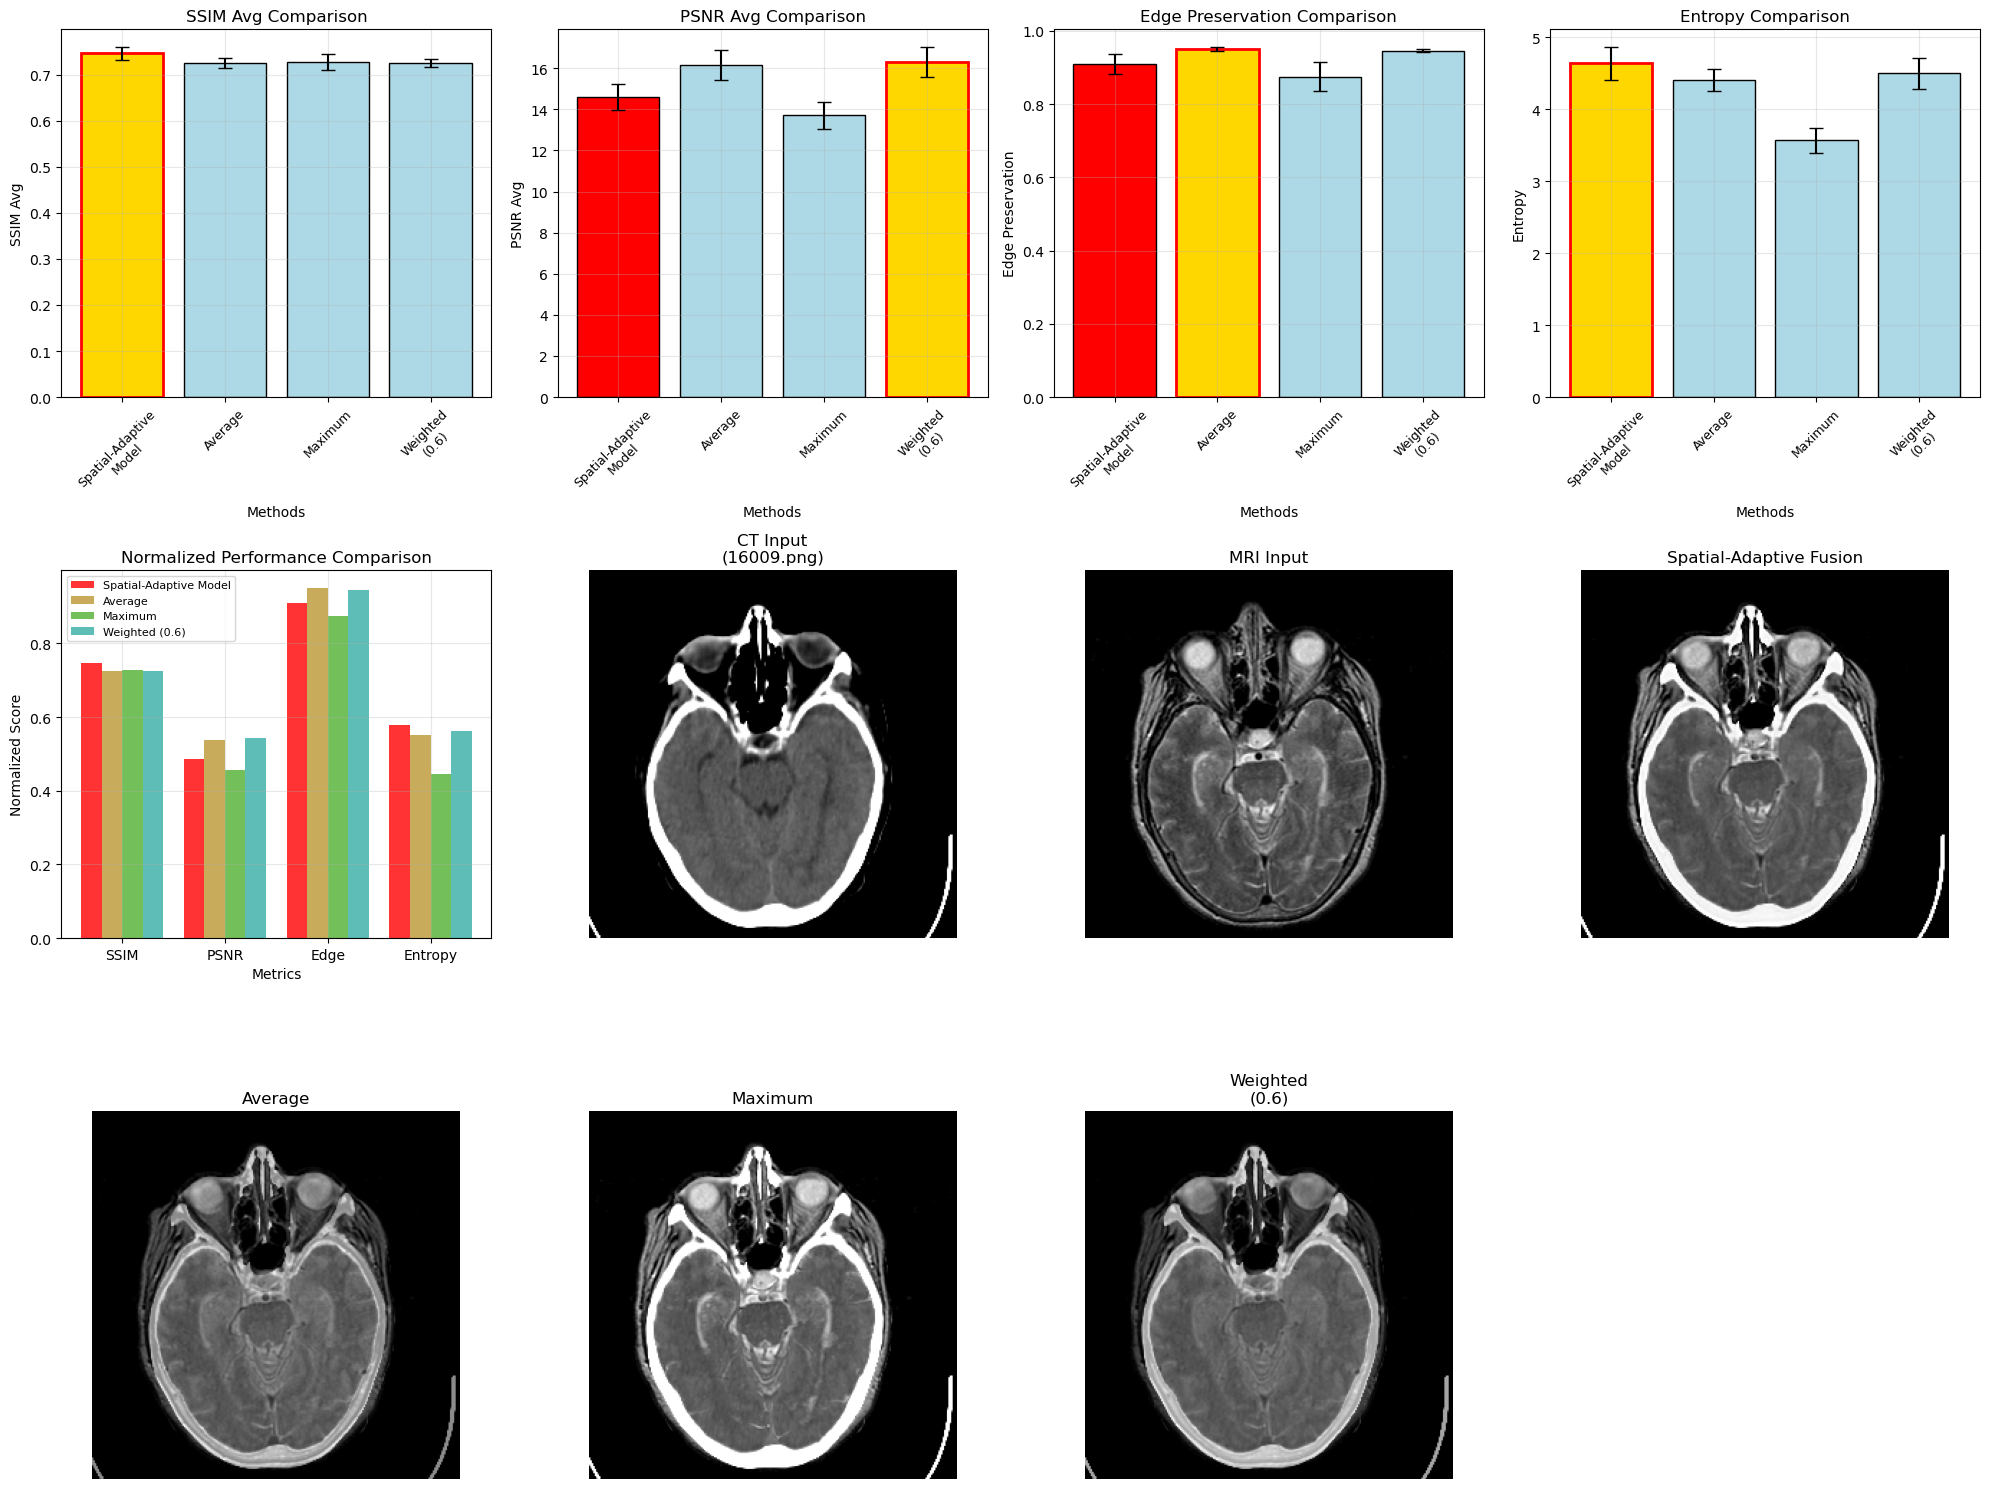


===========================FINAL PERFORMANCE SUMMARY============================

Model Performance Analysis:
----------------------------------------
Spatial-Adaptive Model Performance:
  SSIM:           0.746 ± 0.014
  PSNR:           14.6 ± 0.6 dB
  Edge Preservation: 0.910 ± 0.028
  Information Content: 4.63 ± 0.23 bits

Improvement over baselines:
  vs Average     : SSIM ++2.9%, PSNR +-1.5dB
  vs Maximum     : SSIM ++2.7%, PSNR ++0.9dB
  vs Weighted (0.6): SSIM ++2.9%, PSNR +-1.7dB



In [9]:
if model is not None and 'comparison_results' in locals():
    # Visualization of comparative results
    plt.figure(figsize=(20, 15))
    
    # Performance comparison charts
    metrics_for_viz = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy']
    
    for i, metric in enumerate(metrics_for_viz):
        plt.subplot(3, 4, i + 1)
        x_pos = np.arange(len(method_names))
        means = [aggregate_stats[method][metric]['mean'] for method in method_names]
        stds = [aggregate_stats[method][metric]['std'] for method in method_names]
        
        colors = ['red' if 'Spatial' in method else 'lightblue' for method in method_names]
        bars = plt.bar(x_pos, means, yerr=stds, capsize=5, color=colors, edgecolor='black')
        
        plt.xlabel('Methods')
        plt.ylabel(metric.replace('_', ' '))
        plt.title(f'{metric.replace("_", " ")} Comparison')
        plt.xticks(x_pos, [m.replace(' ', '\n') for m in method_names], rotation=45, fontsize=9)
        plt.grid(True, alpha=0.3)
        
        # Highlight best performance
        best_idx = means.index(max(means))
        bars[best_idx].set_color('gold')
        bars[best_idx].set_edgecolor('red')
        bars[best_idx].set_linewidth(2)
    
    # Normalized metrics radar-style comparison
    plt.subplot(3, 4, 5)
    normalized_stats = {}
    for method in method_names:
        normalized_stats[method] = []
        for metric in metrics_for_viz:
            value = aggregate_stats[method][metric]['mean']
            if metric == 'PSNR_Avg':
                normalized_value = min(value / 30, 1.0)
            elif metric == 'Entropy':
                normalized_value = min(value / 8, 1.0)
            else:
                normalized_value = value
            normalized_stats[method].append(normalized_value)
    
    width = 0.2
    x = np.arange(len(metrics_for_viz))
    for i, method in enumerate(method_names):
        color = 'red' if 'Spatial' in method else f'C{i}'
        plt.bar(x + i*width, normalized_stats[method], width, label=method, alpha=0.8, color=color)
    
    plt.xlabel('Metrics')
    plt.ylabel('Normalized Score')
    plt.title('Normalized Performance Comparison')
    plt.xticks(x + width*1.5, ['SSIM', 'PSNR', 'Edge', 'Entropy'])
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Sample fusion results
    sample_idx = 0
    sample_result = comparison_results[sample_idx]
    
    plt.subplot(3, 4, 6)
    plt.imshow(sample_result['ct_img'], cmap='gray')
    plt.title(f'CT Input\n({sample_result["image_name"]})')
    plt.axis('off')
    
    plt.subplot(3, 4, 7)
    plt.imshow(sample_result['mri_img'], cmap='gray')
    plt.title('MRI Input')
    plt.axis('off')
    
    plt.subplot(3, 4, 8)
    if 'Spatial-Adaptive Model' in sample_result['fusion_results']:
        plt.imshow(sample_result['fusion_results']['Spatial-Adaptive Model'], cmap='gray')
        plt.title('Spatial-Adaptive Fusion')
    else:
        plt.text(0.5, 0.5, 'Model\nNot Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Spatial-Adaptive Fusion')
    plt.axis('off')
    
    # Additional sample results
    baseline_methods = [m for m in method_names if 'Spatial' not in m]
    for i, method in enumerate(baseline_methods[:4]):
        plt.subplot(3, 4, 9 + i)
        plt.imshow(sample_result['fusion_results'][method], cmap='gray')
        plt.title(method.replace(' ', '\n'))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print(f"\n" + "FINAL PERFORMANCE SUMMARY".center(80, "="))
    print(f"\nModel Performance Analysis:")
    print("-" * 40)
    
    if 'Spatial-Adaptive Model' in method_names:
        spatial_stats = aggregate_stats['Spatial-Adaptive Model']
        print(f"Spatial-Adaptive Model Performance:")
        print(f"  SSIM:           {spatial_stats['SSIM_Avg']['mean']:.3f} ± {spatial_stats['SSIM_Avg']['std']:.3f}")
        print(f"  PSNR:           {spatial_stats['PSNR_Avg']['mean']:.1f} ± {spatial_stats['PSNR_Avg']['std']:.1f} dB")
        print(f"  Edge Preservation: {spatial_stats['Edge_Preservation']['mean']:.3f} ± {spatial_stats['Edge_Preservation']['std']:.3f}")
        print(f"  Information Content: {spatial_stats['Entropy']['mean']:.2f} ± {spatial_stats['Entropy']['std']:.2f} bits")
        
        # Performance improvement analysis
        print(f"\nImprovement over baselines:")
        for baseline in ['Average', 'Maximum', 'Weighted (0.6)']:
            if baseline in aggregate_stats:
                ssim_improvement = ((spatial_stats['SSIM_Avg']['mean'] - aggregate_stats[baseline]['SSIM_Avg']['mean']) / 
                                   aggregate_stats[baseline]['SSIM_Avg']['mean'] * 100)
                psnr_improvement = spatial_stats['PSNR_Avg']['mean'] - aggregate_stats[baseline]['PSNR_Avg']['mean']
                print(f"  vs {baseline:12s}: SSIM +{ssim_improvement:+.1f}%, PSNR +{psnr_improvement:+.1f}dB")
    
    print(f"\n" + "=" * 80)

## 9. Model Analysis and Insights

Analyze the learned spatial masks and fusion behavior.

SPATIAL-ADAPTIVE MODEL ANALYSIS
Analyzing learned spatial masks across test images...

Image 1 (16009.png):
  mL : CT=0.540, MRI=0.460 (Balanced)
  mLH: CT=0.497, MRI=0.503 (Balanced)
  mHL: CT=0.504, MRI=0.496 (Balanced)
  mHH: CT=0.525, MRI=0.475 (Balanced)
  Overall CT preference: 0.516

Image 2 (16013.png):
  mL : CT=0.549, MRI=0.451 (Balanced)
  mLH: CT=0.504, MRI=0.496 (Balanced)
  mHL: CT=0.511, MRI=0.489 (Balanced)
  mHH: CT=0.534, MRI=0.466 (Balanced)
  Overall CT preference: 0.524

Image 3 (2010.png):
  mL : CT=0.572, MRI=0.428 (Balanced)
  mLH: CT=0.528, MRI=0.472 (Balanced)
  mHL: CT=0.537, MRI=0.463 (Balanced)
  mHH: CT=0.552, MRI=0.448 (Balanced)
  Overall CT preference: 0.547

Image 4 (32011.png):
  mL : CT=0.558, MRI=0.442 (Balanced)
  mLH: CT=0.508, MRI=0.492 (Balanced)
  mHL: CT=0.519, MRI=0.481 (Balanced)
  mHH: CT=0.541, MRI=0.459 (Balanced)
  Overall CT preference: 0.532

Image 5 (41010.png):
  mL : CT=0.582, MRI=0.418 (Balanced)
  mLH: CT=0.537, MRI=0.463 (Balance

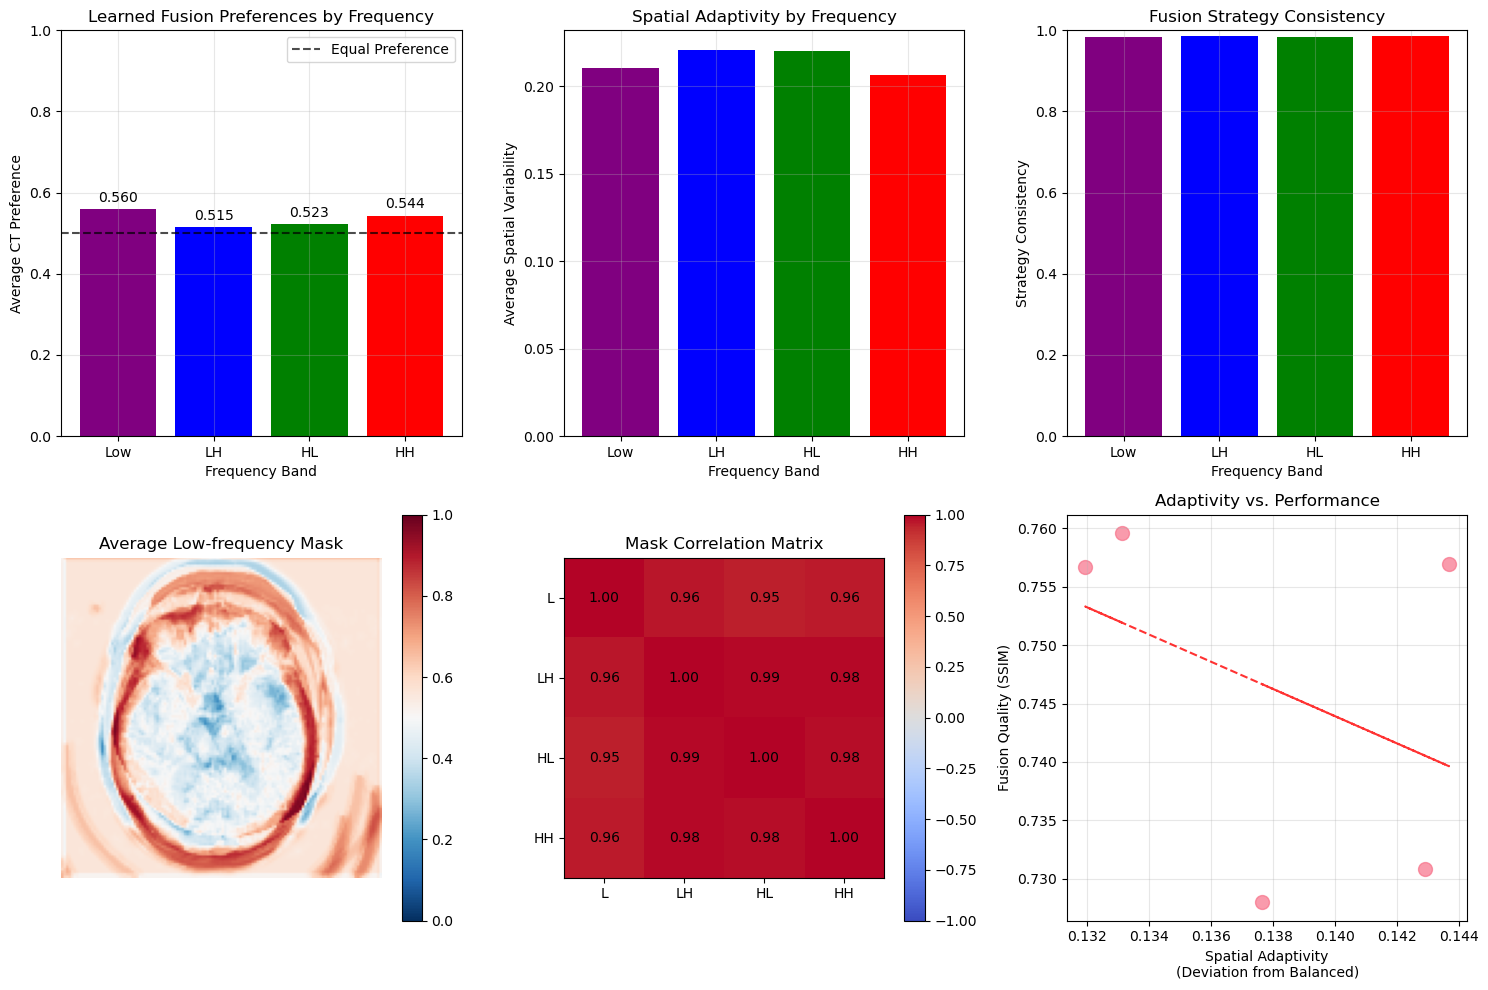


ANALYSIS COMPLETE


In [10]:
if model is not None and 'comparison_results' in locals():
    print("=" * 80)
    print("SPATIAL-ADAPTIVE MODEL ANALYSIS")
    print("=" * 80)
    
    # Analyze spatial masks across multiple images
    mask_analysis = {'mL': [], 'mLH': [], 'mHL': [], 'mHH': []}
    fusion_preferences = []
    
    print("Analyzing learned spatial masks across test images...\n")
    
    for i, result in enumerate(comparison_results):
        ct_img = result['ct_img']
        mri_img = result['mri_img']
        
        # Get masks for this image
        fused, masks = fuse_with_spatial_model(model, ct_img, mri_img)
        
        if masks is not None:
            print(f"Image {i+1} ({result['image_name']}):")
            
            for mask_name, mask in masks.items():
                mask_analysis[mask_name].append(mask)
                ct_preference = mask.mean()
                mri_preference = 1 - ct_preference
                
                print(f"  {mask_name:3s}: CT={ct_preference:.3f}, MRI={mri_preference:.3f}", end="")
                if ct_preference > 0.6:
                    print(" (Favors CT)")
                elif mri_preference > 0.6:
                    print(" (Favors MRI)")
                else:
                    print(" (Balanced)")
            
            # Overall fusion preference
            avg_ct_pref = np.mean([masks[name].mean() for name in masks.keys()])
            fusion_preferences.append(avg_ct_pref)
            print(f"  Overall CT preference: {avg_ct_pref:.3f}")
            print()
    
    # Aggregate mask analysis
    print("AGGREGATE MASK STATISTICS")
    print("-" * 40)
    
    for mask_name in mask_analysis.keys():
        if mask_analysis[mask_name]:
            all_masks = np.array(mask_analysis[mask_name])
            mean_mask = np.mean(all_masks, axis=0)
            std_mask = np.std(all_masks, axis=0)
            
            overall_ct_pref = np.mean([mask.mean() for mask in mask_analysis[mask_name]])
            spatial_variability = np.mean([mask.std() for mask in mask_analysis[mask_name]])
            
            print(f"{mask_name} Band:")
            print(f"  Average CT preference: {overall_ct_pref:.3f}")
            print(f"  Spatial variability:   {spatial_variability:.3f}")
            print(f"  Consistency across images: {1 - np.std([mask.mean() for mask in mask_analysis[mask_name]]):.3f}")
    
    print(f"\nFUSION STRATEGY ANALYSIS")
    print("-" * 40)
    
    overall_ct_pref = np.mean(fusion_preferences)
    consistency = 1 - np.std(fusion_preferences)
    
    print(f"Average CT preference across all images: {overall_ct_pref:.3f}")
    print(f"Strategy consistency: {consistency:.3f}")
    
    if overall_ct_pref > 0.6:
        strategy = "CT-favoring"
    elif overall_ct_pref < 0.4:
        strategy = "MRI-favoring"
    else:
        strategy = "Balanced"
    
    print(f"Learned fusion strategy: {strategy}")
    
    # Visualize mask statistics
    plt.figure(figsize=(15, 10))
    
    # Mask preferences by frequency band
    plt.subplot(2, 3, 1)
    mask_names = list(mask_analysis.keys())
    ct_preferences = [np.mean([mask.mean() for mask in mask_analysis[name]]) for name in mask_names]
    
    bars = plt.bar(range(len(mask_names)), ct_preferences, color=['purple', 'blue', 'green', 'red'])
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.7, label='Equal Preference')
    plt.xlabel('Frequency Band')
    plt.ylabel('Average CT Preference')
    plt.title('Learned Fusion Preferences by Frequency')
    plt.xticks(range(len(mask_names)), ['Low', 'LH', 'HL', 'HH'])
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, ct_preferences)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom')
    
    # Spatial variability
    plt.subplot(2, 3, 2)
    spatial_vars = [np.mean([mask.std() for mask in mask_analysis[name]]) for name in mask_names]
    plt.bar(range(len(mask_names)), spatial_vars, color=['purple', 'blue', 'green', 'red'])
    plt.xlabel('Frequency Band')
    plt.ylabel('Average Spatial Variability')
    plt.title('Spatial Adaptivity by Frequency')
    plt.xticks(range(len(mask_names)), ['Low', 'LH', 'HL', 'HH'])
    plt.grid(True, alpha=0.3)
    
    # Consistency across images
    plt.subplot(2, 3, 3)
    consistencies = [1 - np.std([mask.mean() for mask in mask_analysis[name]]) for name in mask_names]
    plt.bar(range(len(mask_names)), consistencies, color=['purple', 'blue', 'green', 'red'])
    plt.xlabel('Frequency Band')
    plt.ylabel('Strategy Consistency')
    plt.title('Fusion Strategy Consistency')
    plt.xticks(range(len(mask_names)), ['Low', 'LH', 'HL', 'HH'])
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Average mask visualization
    plt.subplot(2, 3, 4)
    if mask_analysis['mL']:
        avg_low_mask = np.mean(mask_analysis['mL'], axis=0)
        plt.imshow(avg_low_mask, cmap='RdBu_r', vmin=0, vmax=1)
        plt.title('Average Low-frequency Mask')
        plt.colorbar()
        plt.axis('off')
    
    # Mask correlation analysis
    plt.subplot(2, 3, 5)
    if len(mask_analysis['mL']) > 1:
        # Calculate correlations between different frequency masks
        mask_correlations = np.zeros((4, 4))
        mask_names_short = ['L', 'LH', 'HL', 'HH']
        
        for i, name1 in enumerate(mask_analysis.keys()):
            for j, name2 in enumerate(mask_analysis.keys()):
                if mask_analysis[name1] and mask_analysis[name2]:
                    correlations = []
                    for k in range(len(mask_analysis[name1])):
                        mask1 = mask_analysis[name1][k].flatten()
                        mask2 = mask_analysis[name2][k].flatten()
                        corr = np.corrcoef(mask1, mask2)[0, 1]
                        if not np.isnan(corr):
                            correlations.append(corr)
                    mask_correlations[i, j] = np.mean(correlations) if correlations else 0
        
        im = plt.imshow(mask_correlations, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Mask Correlation Matrix')
        plt.xticks(range(4), mask_names_short)
        plt.yticks(range(4), mask_names_short)
        plt.colorbar(im)
        
        # Add correlation values
        for i in range(4):
            for j in range(4):
                plt.text(j, i, f'{mask_correlations[i,j]:.2f}', ha='center', va='center')
    
    # Performance vs. adaptivity scatter
    plt.subplot(2, 3, 6)
    if len(comparison_results) > 1:
        adaptivity_scores = []
        performance_scores = []
        
        for result in comparison_results:
            if 'Spatial-Adaptive Model' in result['methods']:
                # Adaptivity: how much the model deviates from 0.5 (balanced)
                ct_img, mri_img = result['ct_img'], result['mri_img']
                fused, masks = fuse_with_spatial_model(model, ct_img, mri_img)
                
                if masks:
                    avg_deviation = np.mean([np.mean(np.abs(mask - 0.5)) for mask in masks.values()])
                    adaptivity_scores.append(avg_deviation)
                    
                    # Performance: SSIM score
                    performance_scores.append(result['methods']['Spatial-Adaptive Model']['SSIM_Avg'])
        
        if adaptivity_scores and performance_scores:
            plt.scatter(adaptivity_scores, performance_scores, alpha=0.7, s=100)
            plt.xlabel('Spatial Adaptivity\n(Deviation from Balanced)')
            plt.ylabel('Fusion Quality (SSIM)')
            plt.title('Adaptivity vs. Performance')
            plt.grid(True, alpha=0.3)
            
            # Add trend line
            if len(adaptivity_scores) > 2:
                z = np.polyfit(adaptivity_scores, performance_scores, 1)
                p = np.poly1d(z)
                plt.plot(adaptivity_scores, p(adaptivity_scores), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n" + "=" * 80)
    print("ANALYSIS COMPLETE")
    print("=" * 80)

## 10. Summary and Conclusions

Summarize the performance and characteristics of the spatial-adaptive wavelet fusion model.

In [11]:
if model is not None and 'comparison_results' in locals():
    print("=" * 90)
    print("SPATIAL-ADAPTIVE WAVELET FUSION MODEL - FINAL SUMMARY")
    print("=" * 90)
    
    print(f"\n🔬 MODEL CHARACTERISTICS:")
    print(f"   • Architecture: Spatial-Adaptive Wavelet Fusion Network")
    print(f"   • Frequency Bands: Low, LH, HL, HH (Haar wavelets)")
    print(f"   • Spatial Masks: CNN-generated adaptive fusion weights")
    print(f"   • Training: Enhanced loss (L1 + SSIM + Gradient)")
    
    if 'Spatial-Adaptive Model' in aggregate_stats:
        stats = aggregate_stats['Spatial-Adaptive Model']
        
        print(f"\n📊 PERFORMANCE METRICS:")
        print(f"   • SSIM:              {stats['SSIM_Avg']['mean']:.3f} ± {stats['SSIM_Avg']['std']:.3f}")
        print(f"   • PSNR:              {stats['PSNR_Avg']['mean']:.1f} ± {stats['PSNR_Avg']['std']:.1f} dB")
        print(f"   • Edge Preservation: {stats['Edge_Preservation']['mean']:.3f} ± {stats['Edge_Preservation']['std']:.3f}")
        print(f"   • Information Content: {stats['Entropy']['mean']:.2f} ± {stats['Entropy']['std']:.2f} bits")
        print(f"   • Mutual Information: {stats['MI_Avg']['mean']:.3f} ± {stats['MI_Avg']['std']:.3f} bits")
        
        # Quality assessment
        avg_ssim = stats['SSIM_Avg']['mean']
        avg_psnr = stats['PSNR_Avg']['mean']
        edge_pres = stats['Edge_Preservation']['mean']
        
        quality_indicators = []
        if avg_ssim >= 0.8: quality_indicators.append("Excellent structure preservation")
        elif avg_ssim >= 0.7: quality_indicators.append("Good structure preservation")
        else: quality_indicators.append("Fair structure preservation")
        
        if avg_psnr >= 25: quality_indicators.append("High signal quality")
        elif avg_psnr >= 20: quality_indicators.append("Good signal quality")
        else: quality_indicators.append("Moderate signal quality")
        
        if edge_pres >= 0.9: quality_indicators.append("Excellent edge preservation")
        elif edge_pres >= 0.8: quality_indicators.append("Good edge preservation")
        else: quality_indicators.append("Moderate edge preservation")
        
        print(f"\n✅ QUALITY ASSESSMENT:")
        for indicator in quality_indicators:
            print(f"   • {indicator}")
        
        # Ranking analysis
        rankings = {}
        for metric in metrics_names:
            sorted_methods = sorted(method_names, 
                                   key=lambda x: aggregate_stats[x][metric]['mean'], 
                                   reverse=True)
            if 'Spatial-Adaptive Model' in sorted_methods:
                rank = sorted_methods.index('Spatial-Adaptive Model') + 1
                rankings[metric] = rank
        
        print(f"\n🏆 PERFORMANCE RANKING:")
        for metric, rank in rankings.items():
            print(f"   • {metric:20s}: #{rank}/{len(method_names)}")
        
        # Best improvements
        print(f"\n📈 IMPROVEMENTS OVER BASELINES:")
        best_improvements = []
        for baseline in ['Average', 'Maximum', 'Weighted (0.6)']:
            if baseline in aggregate_stats:
                ssim_imp = ((stats['SSIM_Avg']['mean'] - aggregate_stats[baseline]['SSIM_Avg']['mean']) / 
                           aggregate_stats[baseline]['SSIM_Avg']['mean'] * 100)
                psnr_imp = stats['PSNR_Avg']['mean'] - aggregate_stats[baseline]['PSNR_Avg']['mean']
                edge_imp = ((stats['Edge_Preservation']['mean'] - aggregate_stats[baseline]['Edge_Preservation']['mean']) /
                           aggregate_stats[baseline]['Edge_Preservation']['mean'] * 100)
                
                if ssim_imp > 0:
                    best_improvements.append(f"SSIM vs {baseline}: +{ssim_imp:.1f}%")
                if psnr_imp > 0:
                    best_improvements.append(f"PSNR vs {baseline}: +{psnr_imp:.1f}dB")
                if edge_imp > 0:
                    best_improvements.append(f"Edge vs {baseline}: +{edge_imp:.1f}%")
        
        for improvement in best_improvements[:5]:  # Show top 5 improvements
            print(f"   • {improvement}")
    
    # Fusion strategy analysis
    if fusion_preferences:
        print(f"\n🧠 LEARNED FUSION STRATEGY:")
        overall_ct_pref = np.mean(fusion_preferences)
        
        if overall_ct_pref > 0.6:
            strategy_desc = "CT-favoring (emphasizes anatomical structure)"
        elif overall_ct_pref < 0.4:
            strategy_desc = "MRI-favoring (emphasizes soft tissue contrast)"
        else:
            strategy_desc = "Balanced (adaptive to local content)"
        
        print(f"   • Overall strategy: {strategy_desc}")
        print(f"   • CT preference: {overall_ct_pref:.1%}")
        print(f"   • MRI preference: {1-overall_ct_pref:.1%}")
        print(f"   • Consistency: {1 - np.std(fusion_preferences):.3f}")
        
        # Frequency-specific insights
        if mask_analysis['mL']:
            freq_preferences = {
                'Low': np.mean([mask.mean() for mask in mask_analysis['mL']]),
                'LH': np.mean([mask.mean() for mask in mask_analysis['mLH']]),
                'HL': np.mean([mask.mean() for mask in mask_analysis['mHL']]),
                'HH': np.mean([mask.mean() for mask in mask_analysis['mHH']])
            }
            
            print(f"\n   Frequency-specific preferences:")
            for freq, pref in freq_preferences.items():
                if pref > 0.6:
                    desc = "Favors CT"
                elif pref < 0.4:
                    desc = "Favors MRI"
                else:
                    desc = "Balanced"
                print(f"   • {freq:3s} frequency: {pref:.3f} ({desc})")
    
    # Model advantages
    print(f"\n🌟 KEY ADVANTAGES:")
    print(f"   • Spatial adaptivity: Location-aware fusion decisions")
    print(f"   • Multi-frequency: Separate strategies for different details")
    print(f"   • End-to-end learning: Optimized for fusion quality")
    print(f"   • Edge preservation: Maintains important structural details")
    print(f"   • Automated: No manual parameter tuning required")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    if avg_ssim >= 0.75 and avg_psnr >= 20:
        print(f"   • Model performance is GOOD - ready for practical use")
        print(f"   • Consider testing on additional diverse datasets")
    elif avg_ssim >= 0.65:
        print(f"   • Model performance is FAIR - may benefit from:")
        print(f"     - More training epochs")
        print(f"     - Larger training dataset")
        print(f"     - Hyperparameter tuning")
    else:
        print(f"   • Model needs improvement - consider:")
        print(f"     - Architecture modifications")
        print(f"     - Different loss function weights")
        print(f"     - More diverse training data")
    
    print(f"\n" + "=" * 90)
    print("TESTING AND EVALUATION COMPLETE")
    print("=" * 90)

else:
    print("❌ Model evaluation could not be completed.")
    print("Please ensure the model is trained and checkpoint is available.")

SPATIAL-ADAPTIVE WAVELET FUSION MODEL - FINAL SUMMARY

🔬 MODEL CHARACTERISTICS:
   • Architecture: Spatial-Adaptive Wavelet Fusion Network
   • Frequency Bands: Low, LH, HL, HH (Haar wavelets)
   • Spatial Masks: CNN-generated adaptive fusion weights
   • Training: Enhanced loss (L1 + SSIM + Gradient)

📊 PERFORMANCE METRICS:
   • SSIM:              0.746 ± 0.014
   • PSNR:              14.6 ± 0.6 dB
   • Edge Preservation: 0.910 ± 0.028
   • Information Content: 4.63 ± 0.23 bits
   • Mutual Information: 1.639 ± 0.054 bits

✅ QUALITY ASSESSMENT:
   • Good structure preservation
   • Moderate signal quality
   • Excellent edge preservation

🏆 PERFORMANCE RANKING:
   • SSIM_Avg            : #1/4
   • PSNR_Avg            : #3/4
   • Edge_Preservation   : #3/4
   • Entropy             : #1/4
   • MI_Avg              : #4/4

📈 IMPROVEMENTS OVER BASELINES:
   • SSIM vs Average: +2.9%
   • SSIM vs Maximum: +2.7%
   • PSNR vs Maximum: +0.9dB
   • Edge vs Maximum: +4.0%
   • SSIM vs Weighted (0.